**Hard Distillation Loss**

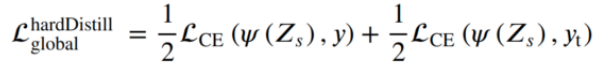

In [1]:
import torch.nn as nn
import torch 
from torch import Tensor 
import torch.nn.functional as F
import numpy as np 
!pip install einops
from einops import reduce, repeat, rearrange

In [2]:
class Hard_Distillation_Loss(nn.Module):
  def __init__(self,
               teacher):
    
    super().__init__()
    self.criterion = nn.CrossEntropyLoss()
    self.teacher = teacher

  def forward(self,
              inputs,
              outputs,
              labels):
    
    base_criterion = self.criterion(outputs, labels)
    with torch.no_grad():
      teacher_outputs = self.teacher(inputs)
    teacher_labels = torch.argmax(teacher_outputs, dim = -1)
    teacher_criterion = self.criterion(outputs, teacher_labels)

    HDL = 0.5 * teacher_criterion + 0.5 * base_criterion 
    return HDL

#Test the loss
teacher = nn.Linear(100, 10)
inputs = torch.randn((10, 100))
outputs = torch.randn((10, 10))
labels = torch.ones(10).long()

hdl = Hard_Distillation_Loss(teacher)
final_loss = hdl(inputs, outputs, labels)
print(final_loss.item())


2.4916882514953613


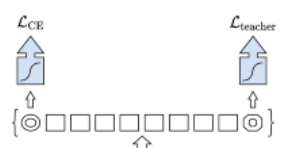

In [3]:
## Here at the output there are 2 qty, 1 class token
# and 1 distillation token, for each loss function

class Hard_Distillation_Loss(nn.Module):
  def __init__(self,
               teacher):
    
    super().__init__()
    self.criterion = nn.CrossEntropyLoss()
    self.teacher = teacher

  def forward(self,
              inputs,
              outputs,
              labels):
    
    true_output, dist_output = outputs
    
    base_criterion = self.criterion(true_output, labels)

    with torch.no_grad():
      teacher_outputs = self.teacher(inputs)
    teacher_labels = torch.argmax(teacher_outputs, dim = -1)
    teacher_criterion = self.criterion(dist_output, teacher_labels)

    HDL = 0.5 * teacher_criterion + 0.5 * base_criterion 
    return HDL


#Test the loss
teacher = nn.Linear(100, 10)
inputs = torch.randn((10, 100))
outputs = (torch.randn((10, 10)), torch.randn((10,10)))
labels = torch.ones(10).long()

hdl = Hard_Distillation_Loss(teacher)
final_loss = hdl(inputs, outputs, labels)
print(final_loss.item())    

2.7368080615997314


## DeiT is just a ViT with an extra Distillation token

In [4]:
from einops.layers.torch import Rearrange

class PatchEmbedding(nn.Module):
  def __init__(self, in_channels : int = 3, patch_size : int = 16, emb_size : int = 768, in_size : int = 224):
    super().__init__()
    self.patch_size = patch_size
    self.projection = nn.Sequential(
        #Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1 = self.patch_size, s2 = self.patch_size),
        nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
        Rearrange('b e (h) (w) -> b (h w) e')
    )

    self.cls_token = nn.Parameter(torch.randn(1,1,emb_size))
    self.positions = nn.Parameter(torch.randn((in_size // patch_size) ** 2 + 1, emb_size))
    self.dst_token = nn.Parameter(torch.randn(1, 1, emb_size))


  def forward(self, x):
    b = x.shape[0]
    x = self.projection(x)
    cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
    dst_tokens = repeat(self.dst_token, '() n e -> b n e', b=b)
    x = torch.cat([cls_tokens, x, dst_tokens] , dim = 1)
    x += self.positions 
    
    return x

In [5]:
class ClassificationHead(nn.Module):
  def __init__(self, emb_dims = 768, n_classes = 1000):
    super().__init__()

    self.emb_dims = emb_dims
    self.classes = n_classes 

    self.fc = nn.Linear(emb_dim, n_classes)
    self.fc_dist = nn.Linear(emb_dim, n_classes)
    self.training = True


  def forward(self, x):
    x_fc, x_dist = x[:, 0], x[:, 1]
    x_out = self.fc(x_fc)
    x_dist_out = self.fc_dist(x_dist)  

    if self.training:
      x = x_out, x_dist_out 

    else:
      x = (x_out + x_dist_out).mean()

    return x    

In [6]:
class ResidualAdd(nn.Module):
  def __init__(self, fn):
    super().__init__()
    self.fn = fn

  def forward(self, x, **kwargs):
    res = x
    x = self.fn(x, **kwargs)
    x += res

    return x  

In [7]:
class MultiHeadAttention(nn.Module):
  def __init__(self, emb_size : int = 768, num_heads : int = 8, dropout : float = 0):
    super().__init__()
    self.emb_size = emb_size
    self.num_heads = num_heads
    self.qkv = nn.Linear(emb_size, 3 * emb_size)  
    self.drop = nn.Dropout(dropout)
    self.projection = nn.Linear(emb_size, emb_size)

  def forward(self, x, mask = None):
    qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h = self.num_heads, qkv = 3)

    queries, keys, values = qkv[0], qkv[1], qkv[2]
    energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)
    if mask is not None:
      fill_value = torch.finfo(torch.float32).min
      energy.mask_fill(~mask, fill_value)

    scaling = self.emb_size ** (1/2)
    att = F.softmax(energy, dim = 1)/scaling 
    #final mult

    out = torch.einsum('bhal, bhlv -> bhav', att, values) 
    out = rearrange(out, "b h n d -> b n (h d)")
    out = self.projection(out)
    return out

In [8]:
class MLPBlock(nn.Sequential):
  def __init__(self, emb_size, expansion = 4, drop_p = 0.):
    super().__init__(
        nn.Linear(emb_size, expansion * emb_size),
        nn.GELU(),
        nn.Dropout(drop_p),
        nn.Linear(expansion * emb_size, emb_size)
    )

In [9]:
class TransformerEncoderBlock(nn.Sequential):
  def __init__(self, 
               emb_size = 768,
               drop = 0.,
               expansion = 4,
               forward_drop = 0.,
               **kwargs):
    super().__init__(
        ResidualAdd(nn.Sequential(
            nn.LayerNorm(emb_size),
            MultiHeadAttention(emb_size, **kwargs),
            nn.Dropout(drop)
        )),

        ResidualAdd(nn.Sequential(
            nn.LayerNorm(emb_size),
            MLPBlock(emb_size, expansion, forward_drop),
            nn.Dropout(forward_drop)
        ))
    )

In [10]:
class TransformerEncoder(nn.Sequential):
  def __init__(self, L = 12, **kwargs):
    super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(L)])

In [12]:
class DeiT(nn.Sequential):
  def __init__(self, 
               channels = 3,
               patch_size = 16,
               emb_size = 768,
               input_size = 224,
               L = 12,
               n_classes = 1000,
               **kwargs):
    super().__init__(
        PatchEmbedding(channels, patch_size, emb_size, input_size),
        TransformerEncoder(L, **kwargs),
        ClassificationHead(emb_size, n_classes)
    )

In [ ]:
# teacher = ViT.vit_large_patch16_224()
# student = DeiT.deit_small_patch16_224()

# optimizer = torch.optim.Adam(student.parameters())
# criterion = Hard_Distillation_Loss(teacher)

# for in_data in data:
#   inputs, labels = in_data
#   outputs = student(inputs)

#   optimizer.zero_grad()
#   loss = criterion(inputs, outputs, labels)
#   loss.backward()
#   optimizer.step()